In [2]:
from google.colab import files
uploaded = files.upload()

Saving Telco_Customer_Churn.csv to Telco_Customer_Churn.csv


In [5]:
# Telco Customer Churn (Binary Classification)
# Models: Decision Tree, Random Forest, Gradient Boosting (GBM)
# Output: Metrics + Confusion Matrix + ROC Curve + Feature Importance
# Run as ONE CELL in Google Colab.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, classification_report
)
from sklearn.inspection import permutation_importance

plt.rcParams["figure.figsize"] = (8, 5)

# =========================
# 1) Upload & Load
# =========================
print("📌 Upload Telco_Customer_Churn.csv")
uploaded = files.upload()

csv_files = [fn for fn in uploaded.keys() if fn.lower().endswith(".csv")]
if not csv_files:
    raise FileNotFoundError("No CSV found. Please upload Telco_Customer_Churn.csv")

csv_path = f"/content/{csv_files[0]}"
print(f"✅ Using dataset: {csv_path}")

df = pd.read_csv(csv_path)
print("Shape:", df.shape)
display(df.head())

📌 Upload Telco_Customer_Churn.csv


Saving Telco_Customer_Churn.csv to Telco_Customer_Churn (1).csv
✅ Using dataset: /content/Telco_Customer_Churn (1).csv
Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
# =========================
# 2) Basic Cleaning
# =========================
if "Churn" not in df.columns:
    raise KeyError("Column 'Churn' not found. Please check your dataset.")

# Drop ID column if exists
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

# Convert TotalCharges to numeric if exists
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Target mapping
y = df["Churn"].map({"Yes": 1, "No": 0}).astype(int)
X = df.drop(columns=["Churn"])

print("\nTarget distribution (ratio):")
print(y.value_counts(normalize=True))


Target distribution (ratio):
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


In [8]:
# =========================
# 3) Preprocessing
# =========================
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


In [9]:
# =========================
# 4) Split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [10]:
# =========================
# 5) Helpers
# =========================
def get_feature_names(preprocess_obj):
    """Extract feature names from ColumnTransformer + OneHotEncoder."""
    num_features = num_cols
    ohe = preprocess_obj.named_transformers_["cat"].named_steps["onehot"]
    cat_features = ohe.get_feature_names_out(cat_cols).tolist()
    return num_features + cat_features

def plot_top_importances(feature_names, importances, title, top_n=20):
    s = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(top_n)
    s.sort_values().plot(kind="barh")
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

def evaluate_model(name, clf):
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", clf)])
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob)

    print(f"\n===== {name} =====")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {auc:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["No Churn", "Churn"]).plot(values_format="d")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    # ROC curve
    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title(f"{name} - ROC Curve")
    plt.show()

    return pipe, {"Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "AUC": auc}

In [11]:
# =========================
# 6) Models (DT, RF, GBM)
# =========================
dt = DecisionTreeClassifier(
    max_depth=5,
    random_state=42,
    class_weight="balanced"
)

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced",
    min_samples_leaf=2
)

gbm = GradientBoostingClassifier(
    random_state=42
)


===== Decision Tree =====
Accuracy : 0.7551
Precision: 0.5269
Recall   : 0.7594
F1-score : 0.6221
ROC-AUC  : 0.8323

Classification report:
              precision    recall  f1-score   support

           0     0.8966    0.7536    0.8189      1035
           1     0.5269    0.7594    0.6221       374

    accuracy                         0.7551      1409
   macro avg     0.7117    0.7565    0.7205      1409
weighted avg     0.7984    0.7551    0.7667      1409



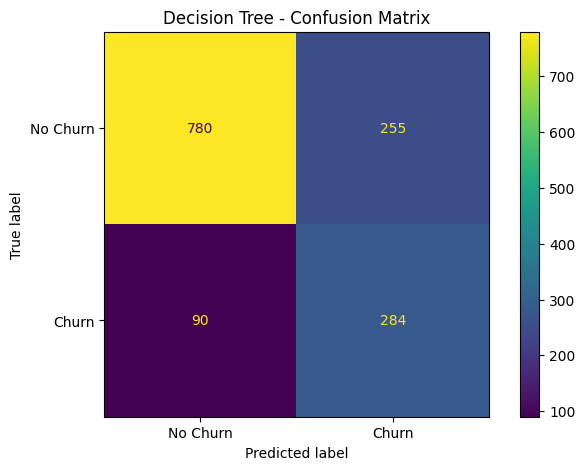

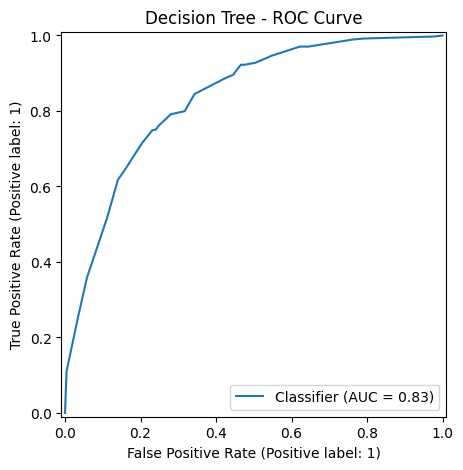


===== Random Forest =====
Accuracy : 0.7842
Precision: 0.5841
Recall   : 0.6497
F1-score : 0.6152
ROC-AUC  : 0.8348

Classification report:
              precision    recall  f1-score   support

           0     0.8681    0.8329    0.8501      1035
           1     0.5841    0.6497    0.6152       374

    accuracy                         0.7842      1409
   macro avg     0.7261    0.7413    0.7326      1409
weighted avg     0.7927    0.7842    0.7877      1409



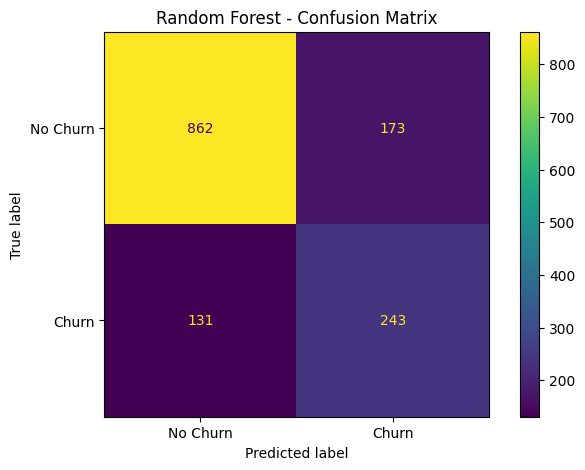

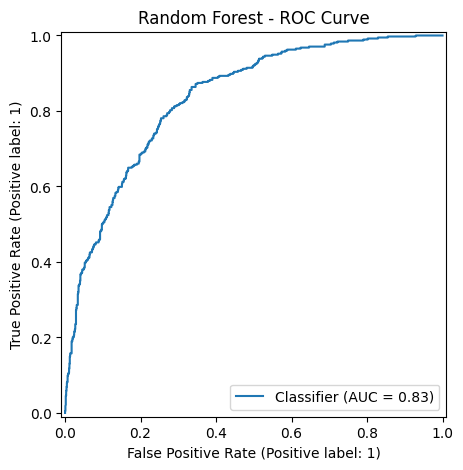


===== GBM (Gradient Boosting) =====
Accuracy : 0.8062
Precision: 0.6735
Recall   : 0.5241
F1-score : 0.5895
ROC-AUC  : 0.8433

Classification report:
              precision    recall  f1-score   support

           0     0.8408    0.9082    0.8732      1035
           1     0.6735    0.5241    0.5895       374

    accuracy                         0.8062      1409
   macro avg     0.7572    0.7161    0.7313      1409
weighted avg     0.7964    0.8062    0.7979      1409



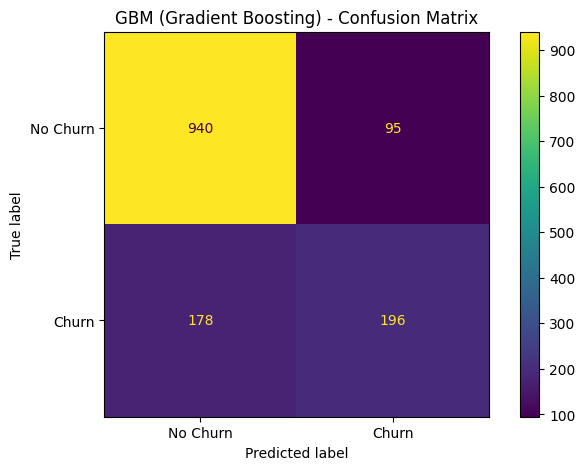

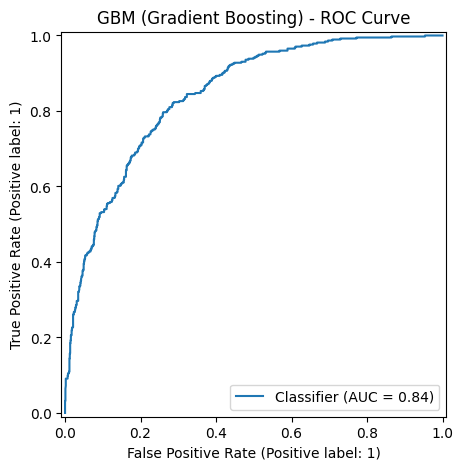


📌 Summary (sorted by AUC):


,Model,Accuracy,Precision,Recall,F1,AUC
2,GBM (Gradient Boosting),0.806246,0.673540,0.524064,0.589474,0.843334
1,Random Forest,0.784244,0.584135,0.649733,0.615190,0.834750
0,Decision Tree,0.755145,0.526902,0.759358,0.622125,0.832279


In [12]:
# =========================
# 7) Train + Evaluate
# =========================
pipes = {}
rows = []

p_dt, r_dt = evaluate_model("Decision Tree", dt)
pipes["Decision Tree"] = p_dt
rows.append(r_dt)

p_rf, r_rf = evaluate_model("Random Forest", rf)
pipes["Random Forest"] = p_rf
rows.append(r_rf)

p_gbm, r_gbm = evaluate_model("GBM (Gradient Boosting)", gbm)
pipes["GBM (Gradient Boosting)"] = p_gbm
rows.append(r_gbm)

summary = pd.DataFrame(rows).sort_values(by="AUC", ascending=False)
print("\n📌 Summary (sorted by AUC):")
display(summary)



🏆 Best model by AUC: GBM (Gradient Boosting)


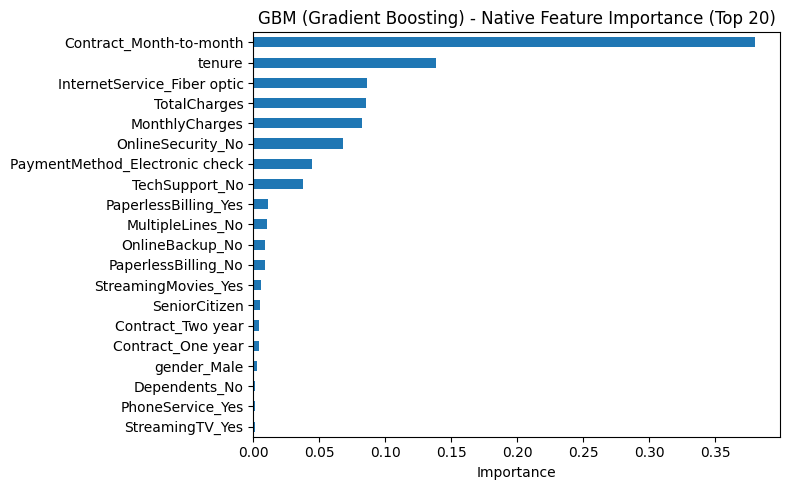


⏳ Computing permutation importance (ROC-AUC scoring)...


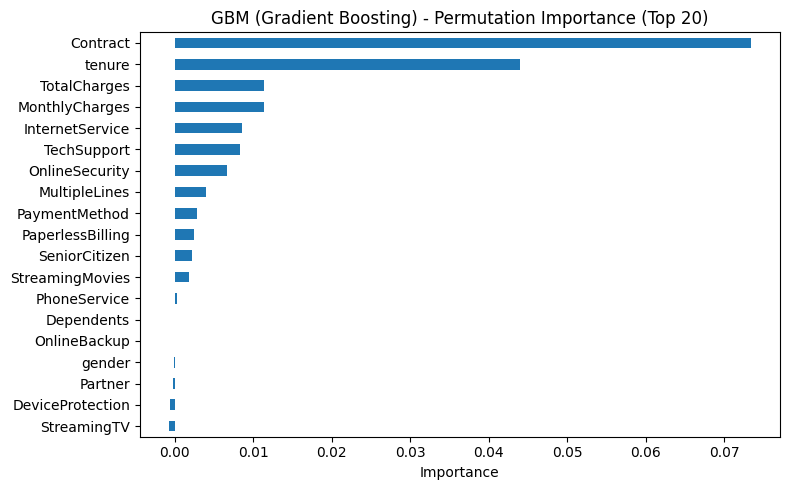


✅ Done! DT + RF + GBM completed with evaluation and feature importance.


In [13]:
# =========================
# 8) Feature Importance (Best model)
# =========================
best_model_name = summary.iloc[0]["Model"]
best_pipe = pipes[best_model_name]
print(f"\n🏆 Best model by AUC: {best_model_name}")

best_pipe.fit(X_train, y_train)
feature_names = get_feature_names(best_pipe.named_steps["preprocess"])

model = best_pipe.named_steps["model"]

# (A) Native feature importance if available
if hasattr(model, "feature_importances_"):
    plot_top_importances(
        feature_names, model.feature_importances_,
        f"{best_model_name} - Native Feature Importance (Top 20)"
    )
else:
    print("⚠️ This model does not have native feature_importances_ (will use permutation importance).")

# (B) Permutation importance (model-agnostic)
print("\n⏳ Computing permutation importance (ROC-AUC scoring)...")
perm = permutation_importance(
    best_pipe, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1, scoring="roc_auc"
)

plot_top_importances(
    X_test.columns, perm.importances_mean, # Changed 'feature_names' to 'X_test.columns' here
    f"{best_model_name} - Permutation Importance (Top 20)"
)

print("\n✅ Done! DT + RF + GBM completed with evaluation and feature importance.")